In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [17]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=10vdMg_RazoIatwrT7azKFX4P02OebU76
To: /content/spx.csv
100% 152k/152k [00:00<00:00, 62.6MB/s]


In [18]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')


df_reg=df
import numpy as np
csv=np.genfromtxt('spx.csv',delimiter=',')

df['SMA_Temp']=df['close'].rolling(window = 200, min_periods = 1).mean()
df['index'] = range(1, len(df) + 1)

df.head()


df

,close,SMA_Temp,index
date,,,
1986-01-02,209.59,209.590000,1
1986-01-03,210.88,210.235000,2
1986-01-06,210.65,210.373333,3
1986-01-07,213.80,211.230000,4
1986-01-08,207.97,210.578000,5
...,...,...,...
2018-06-25,2717.07,2664.416800,8188
2018-06-26,2723.06,2665.724950,8189
2018-06-27,2699.63,2666.782550,8190


In [19]:
std_x_train=np.std(df["close"])
mean_x_train=np.mean(df["close"])

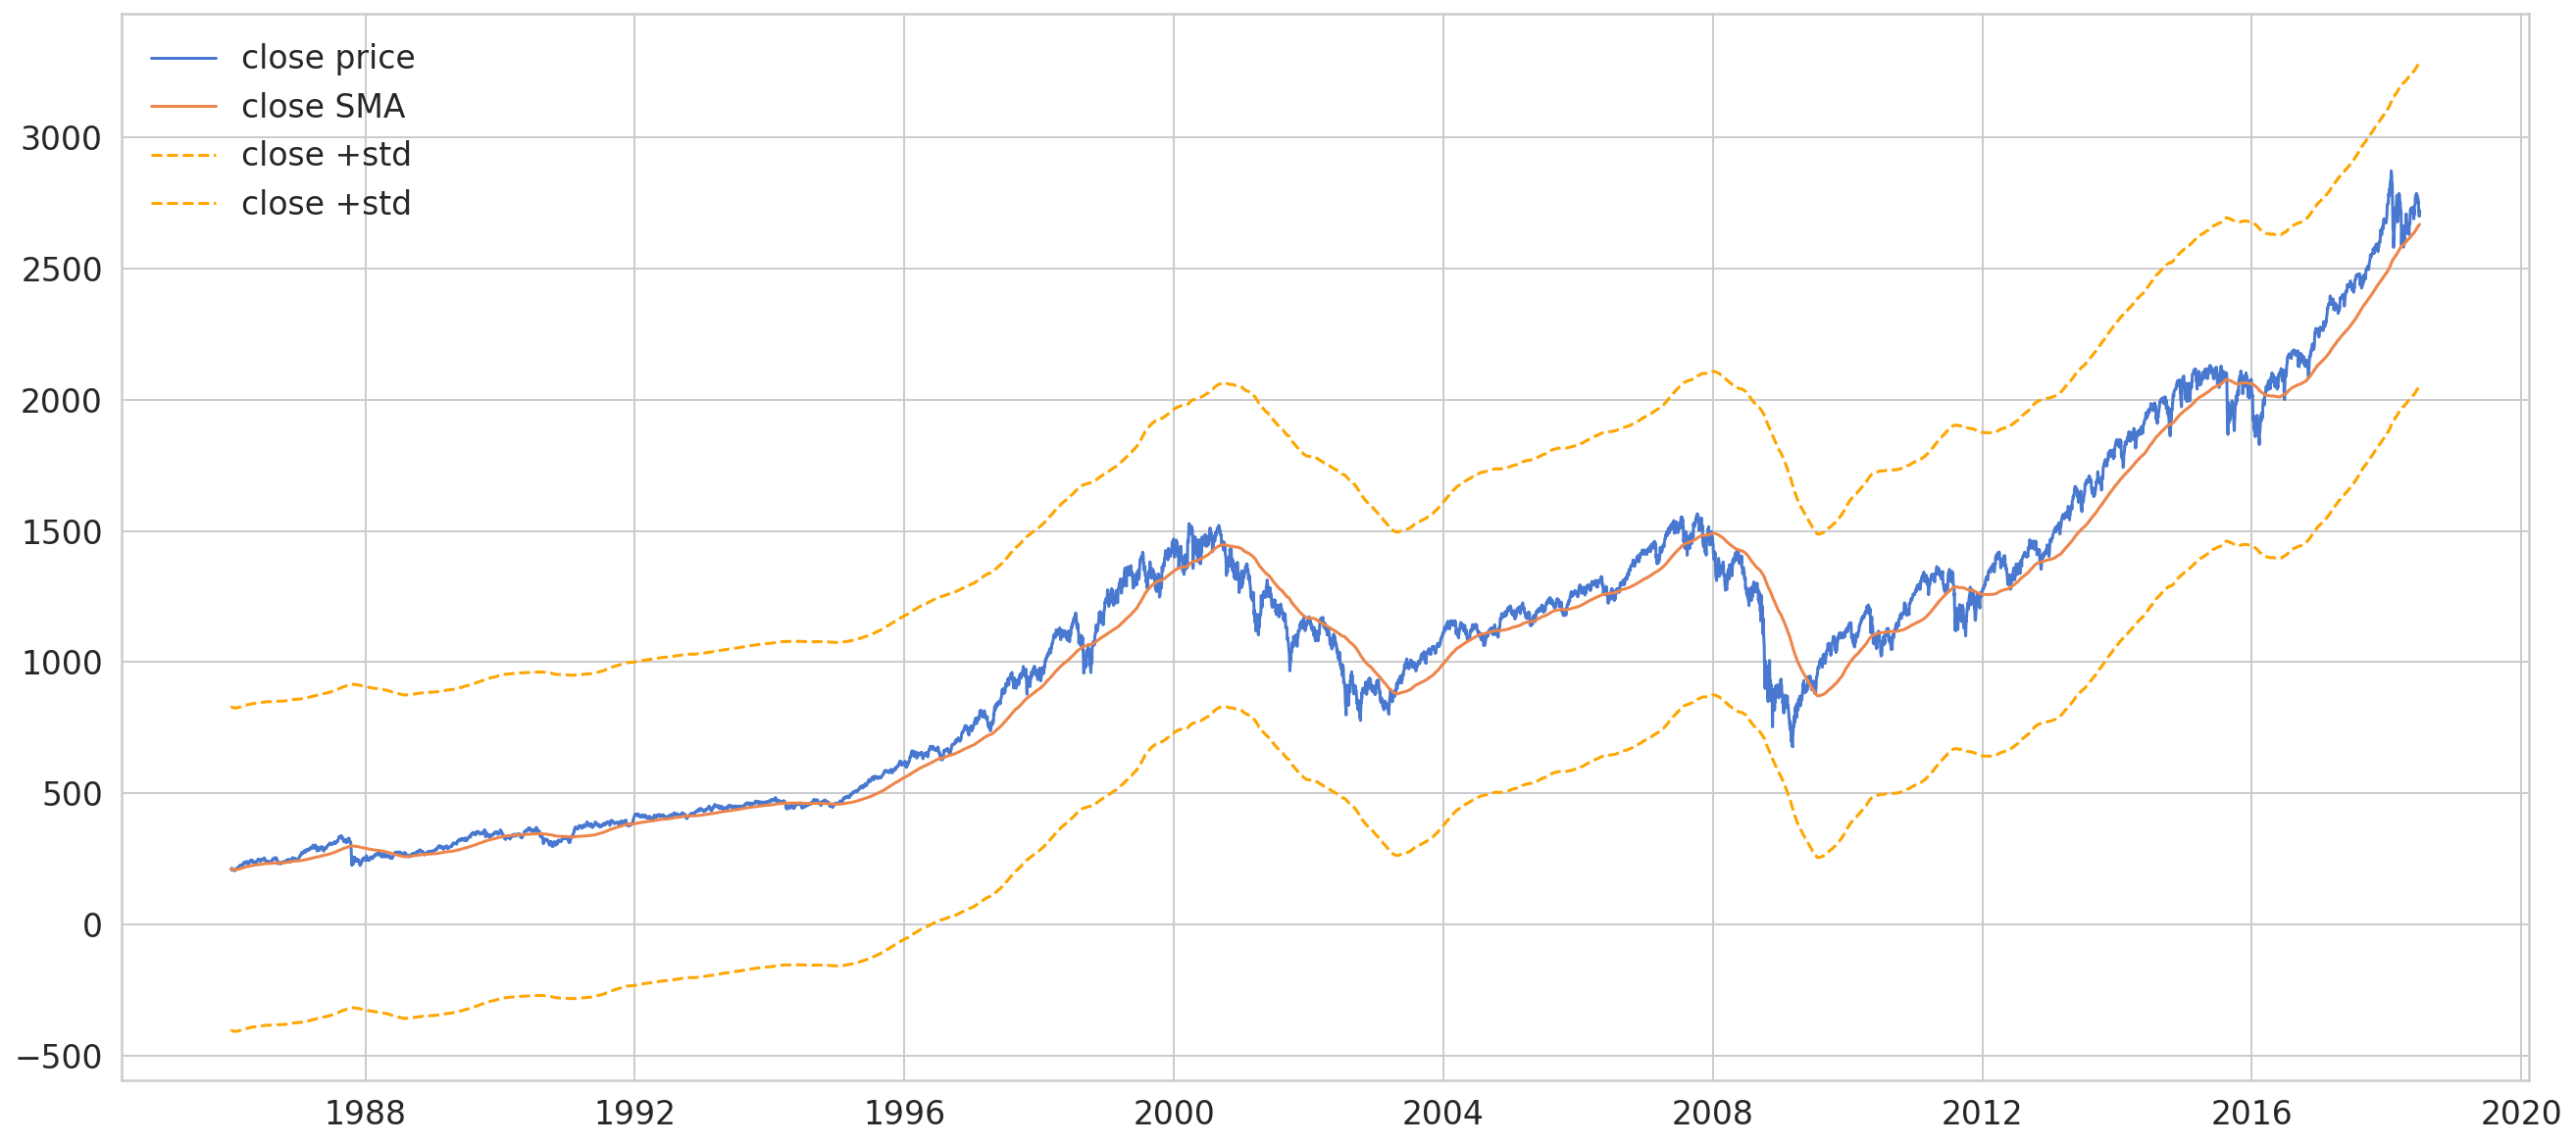

In [20]:
rcParams['figure.figsize'] = 22, 10
import matplotlib.pyplot as plt
      
plt.plot(df.index,df["close"], label='close price')
plt.plot(df.index,df["SMA_Temp"] ,label='close SMA')

plt.plot(df.index,df["SMA_Temp"]+ std_x_train,label='close +std' , color="orange",linestyle='dashed')
plt.plot(df.index,df["SMA_Temp"]- std_x_train,label='close +std', color="orange",linestyle='dashed')

plt.legend();

In [21]:
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6553, 3) (1639, 3)


In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])



train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [23]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [24]:
TIME_STEPS = 30


X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(6523, 30, 1)


In [25]:
model = keras.Sequential()

#encoder
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.1))


#decoder
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))

model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.1))

model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_9 (Dropout)         (None, 30, 64)            0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            65        
 ibuted)                                              

In [26]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/20
184/184 [==============================] - 13s 41ms/step - loss: 0.1824 - val_loss: 0.1502
Epoch 2/20
184/184 [==============================] - 7s 36ms/step - loss: 0.1256 - val_loss: 0.1594
Epoch 3/20
184/184 [==============================] - 13s 69ms/step - loss: 0.1160 - val_loss: 0.1788
Epoch 4/20
184/184 [==============================] - 11s 59ms/step - loss: 0.1350 - val_loss: 0.1478
Epoch 5/20
184/184 [==============================] - 9s 48ms/step - loss: 0.1381 - val_loss: 0.1536
Epoch 6/20
184/184 [==============================] - 8s 44ms/step - loss: 0.1463 - val_loss: 0.2295
Epoch 7/20
184/184 [==============================] - 7s 36ms/step - loss: 0.1264 - val_loss: 0.2700
Epoch 8/20
184/184 [==============================] - 10s 55ms/step - loss: 0.1289 - val_loss: 0.2017
Epoch 9/20
184/184 [==============================] - 9s 49ms/step - loss: 0.1328 - val_loss: 0.1637
Epoch 10/20
184/184 [==============================] - 11s 61ms/step - loss: 0.1231 - v

In [27]:
y_hat=model.predict(X_test)
y_hat.reshape(-1,30)
y_hat.shape

model.evaluate(X_test,y_test)

51/51 [==============================] - 1s 12ms/step - loss: 0.9279


0.9279420375823975

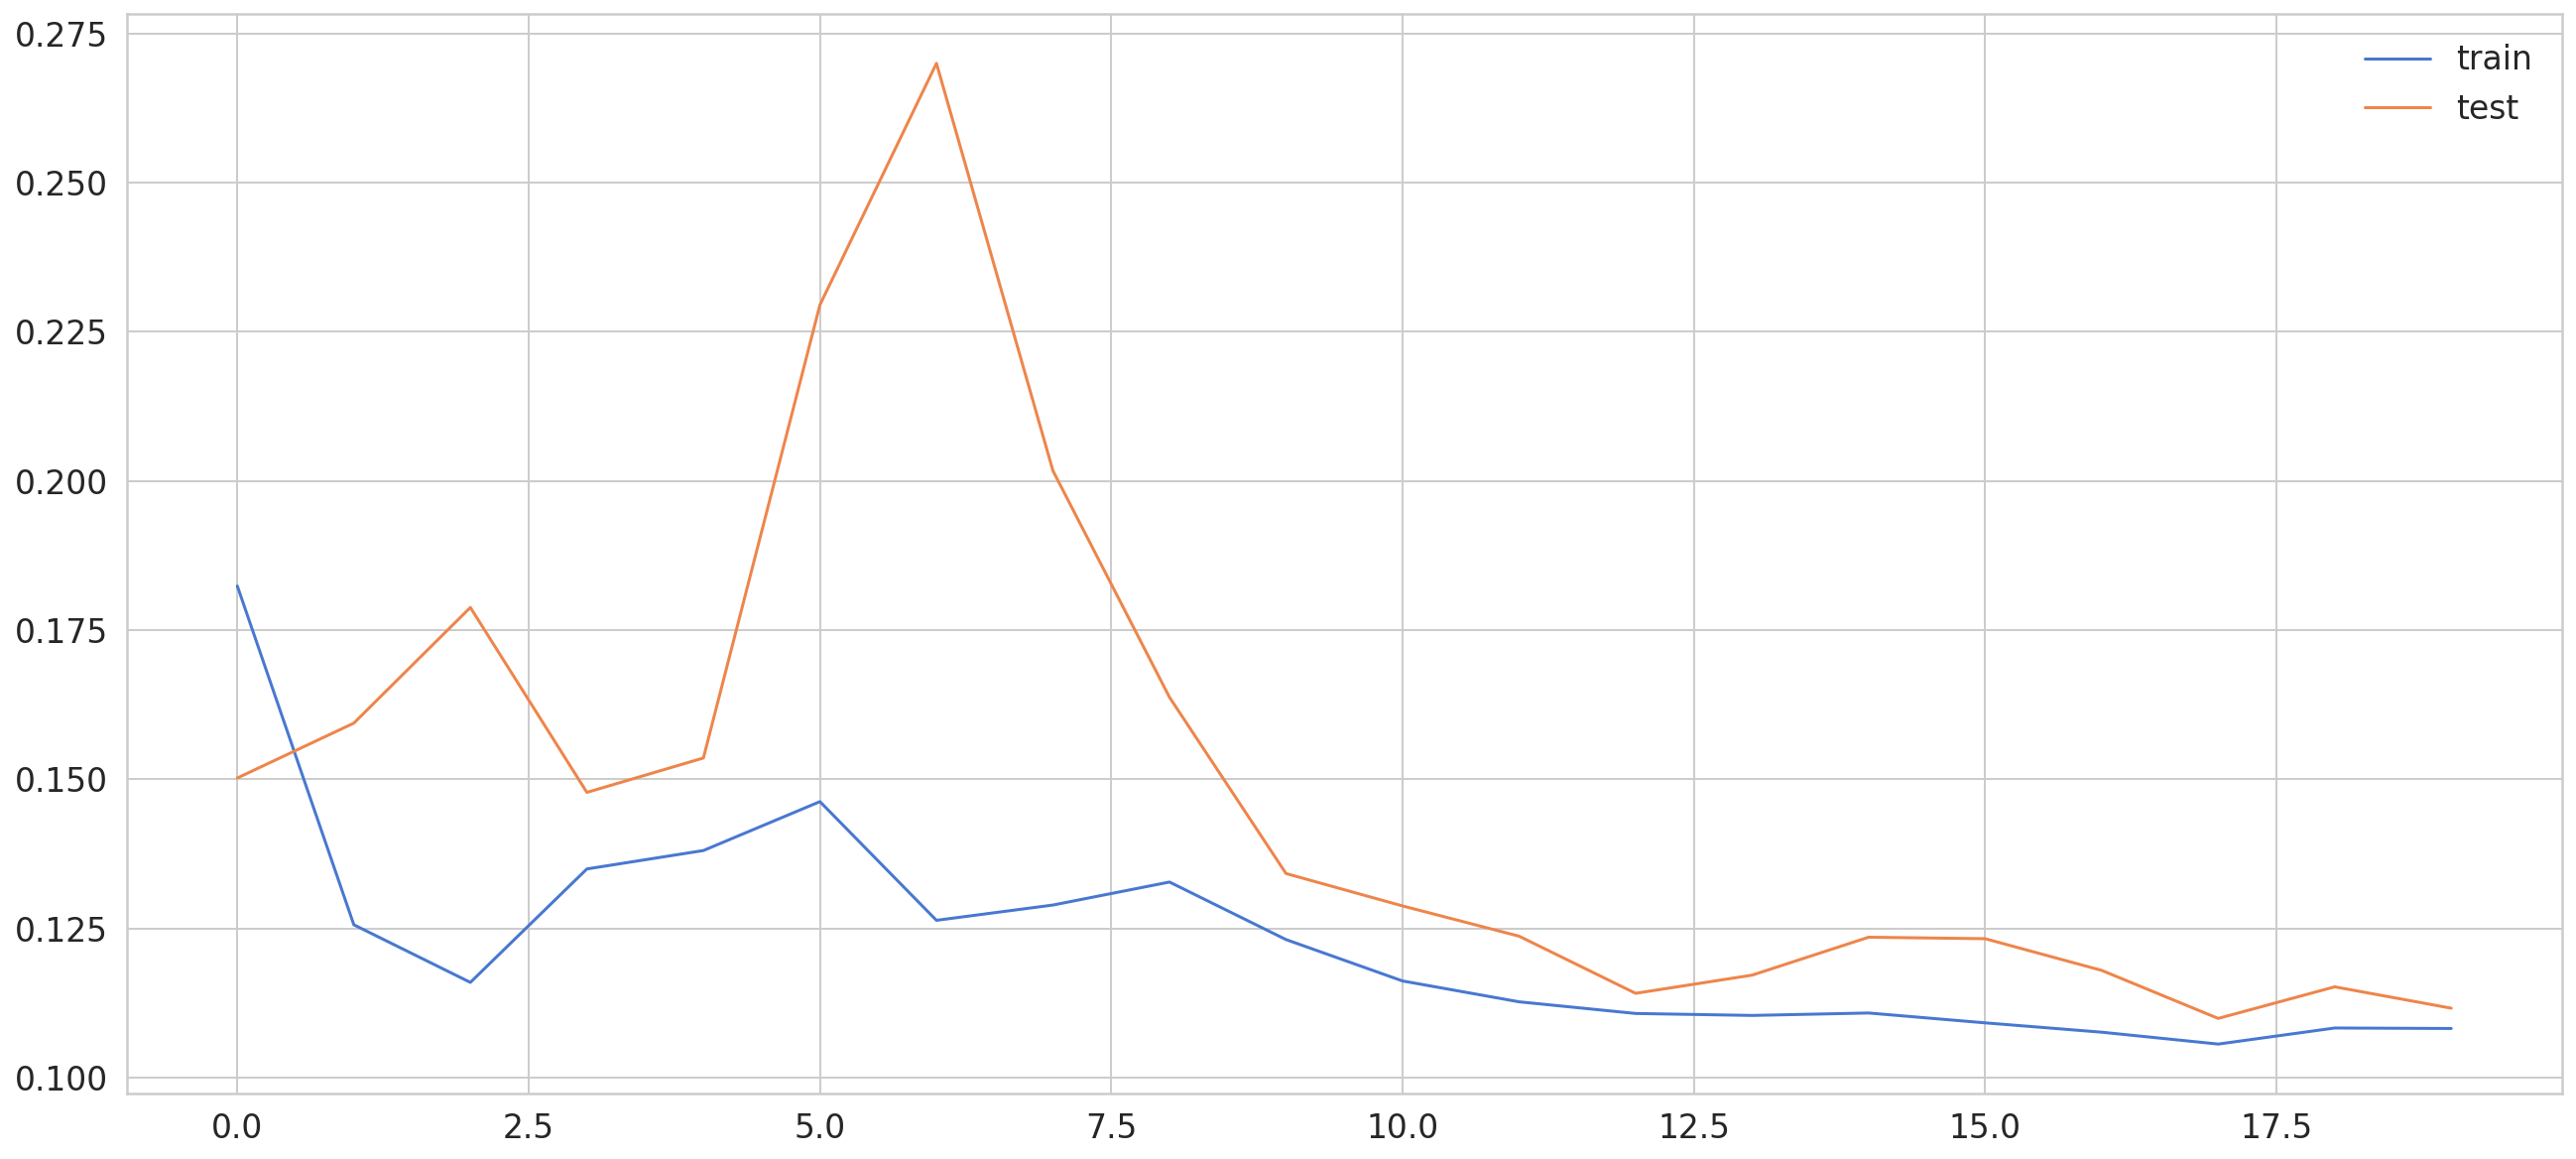

In [28]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [29]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

204/204 [==============================] - 2s 12ms/step


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


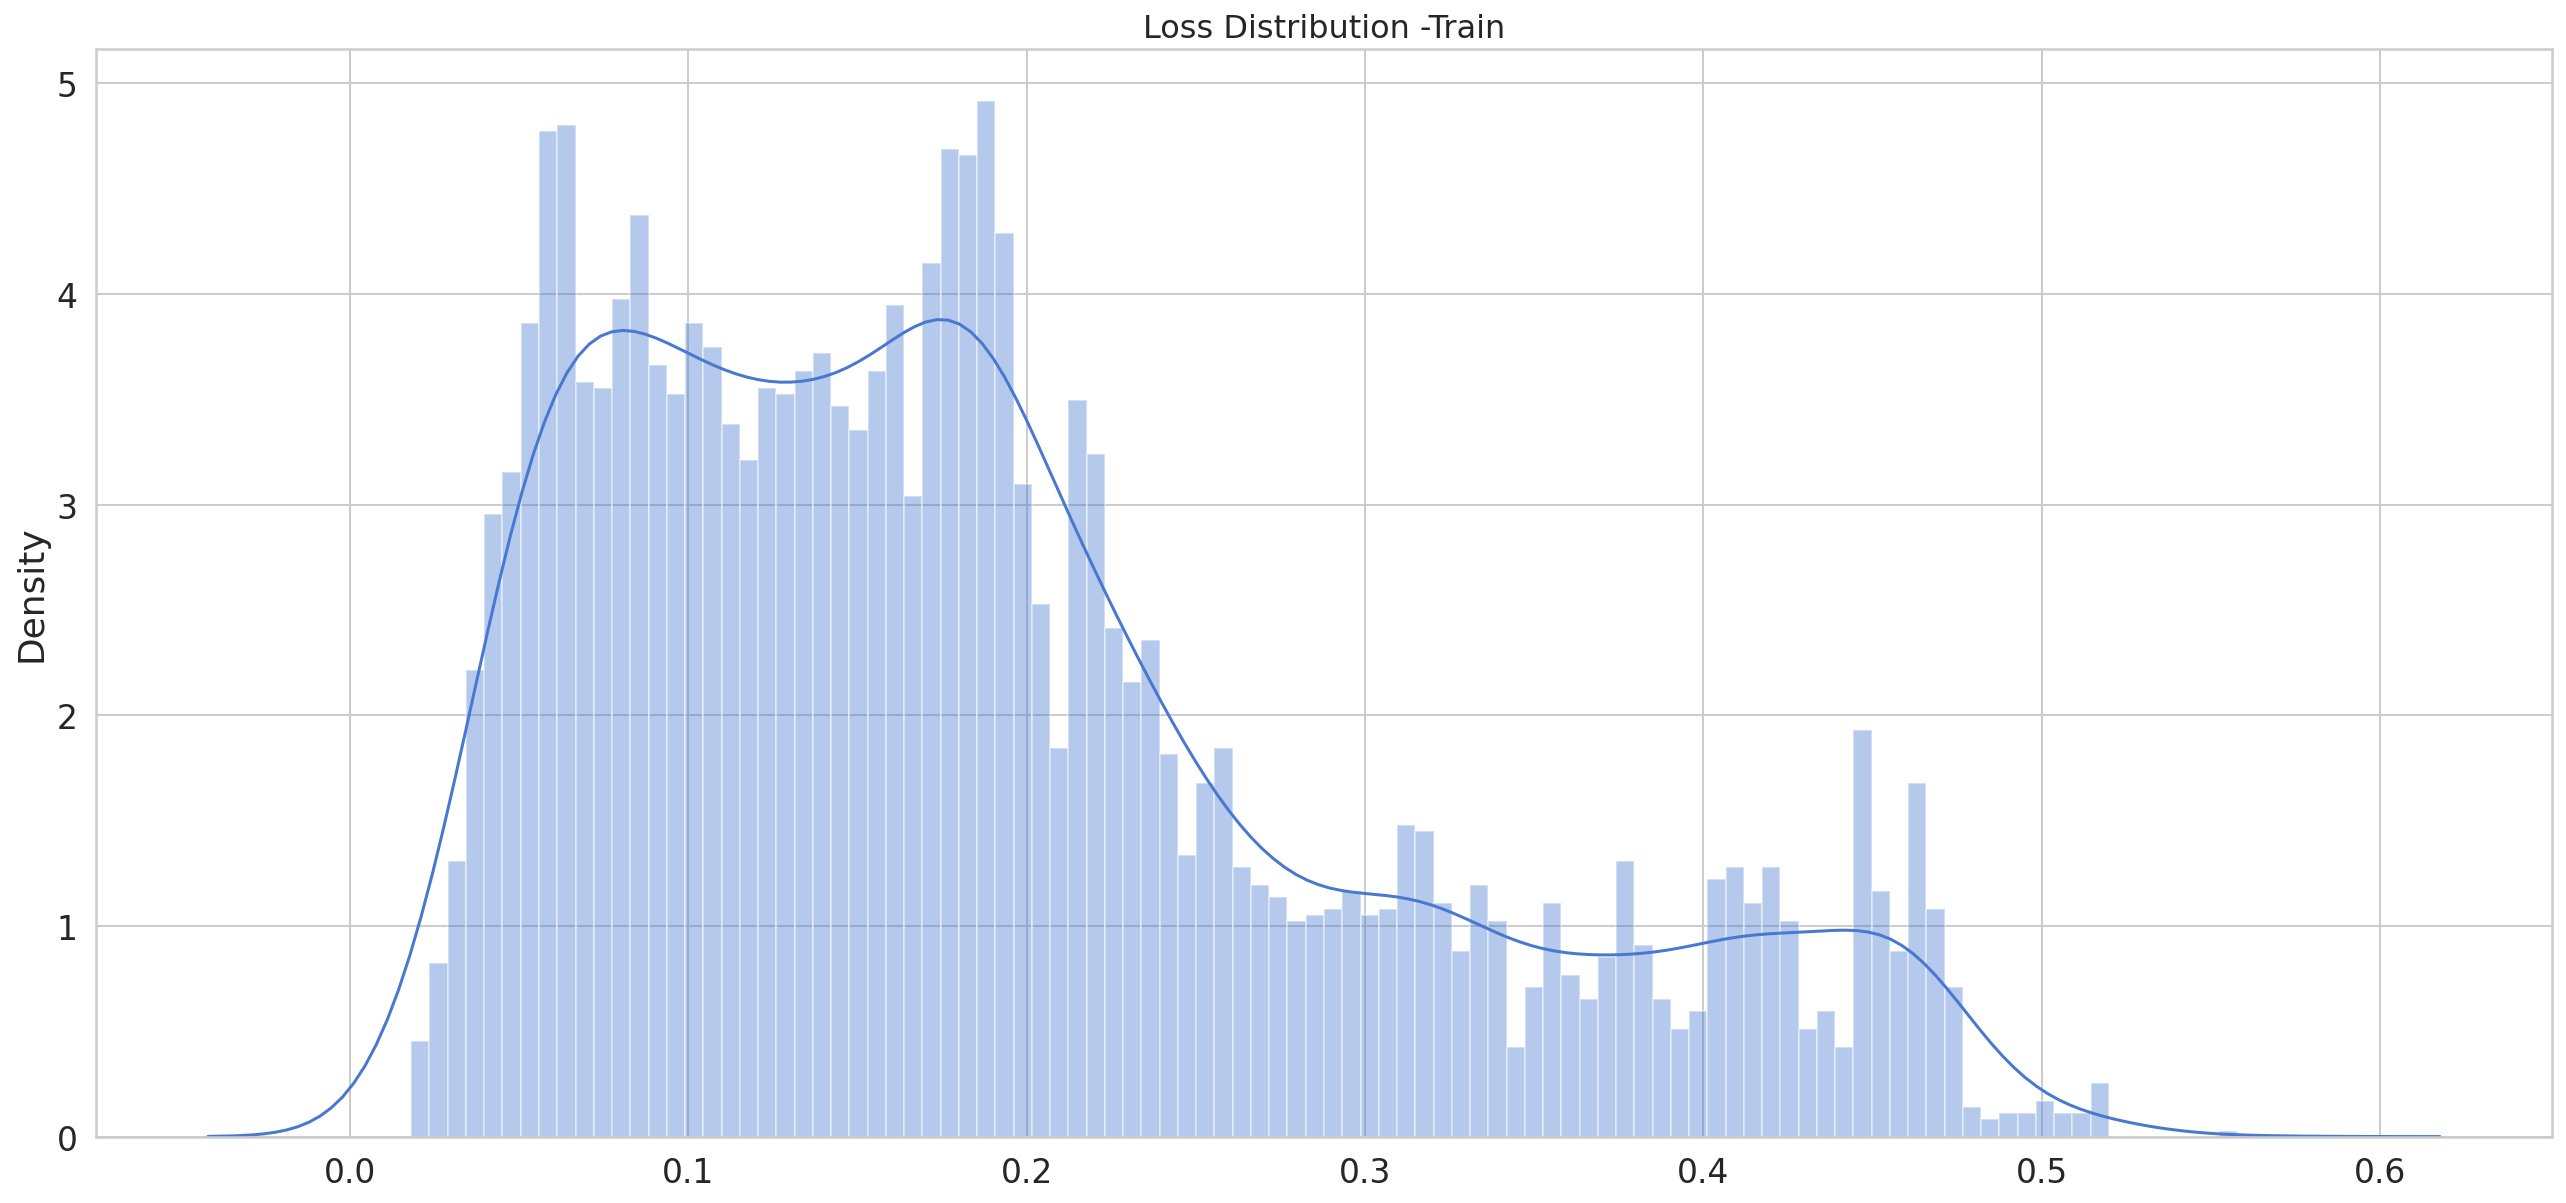

In [30]:
plt.title('Loss Distribution -Train', fontsize=16)
sns.distplot(train_mae_loss, bins=100, kde=True);

In [31]:
X_test_pred = model.predict(X_test)


test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

51/51 [==============================] - 1s 11ms/step


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


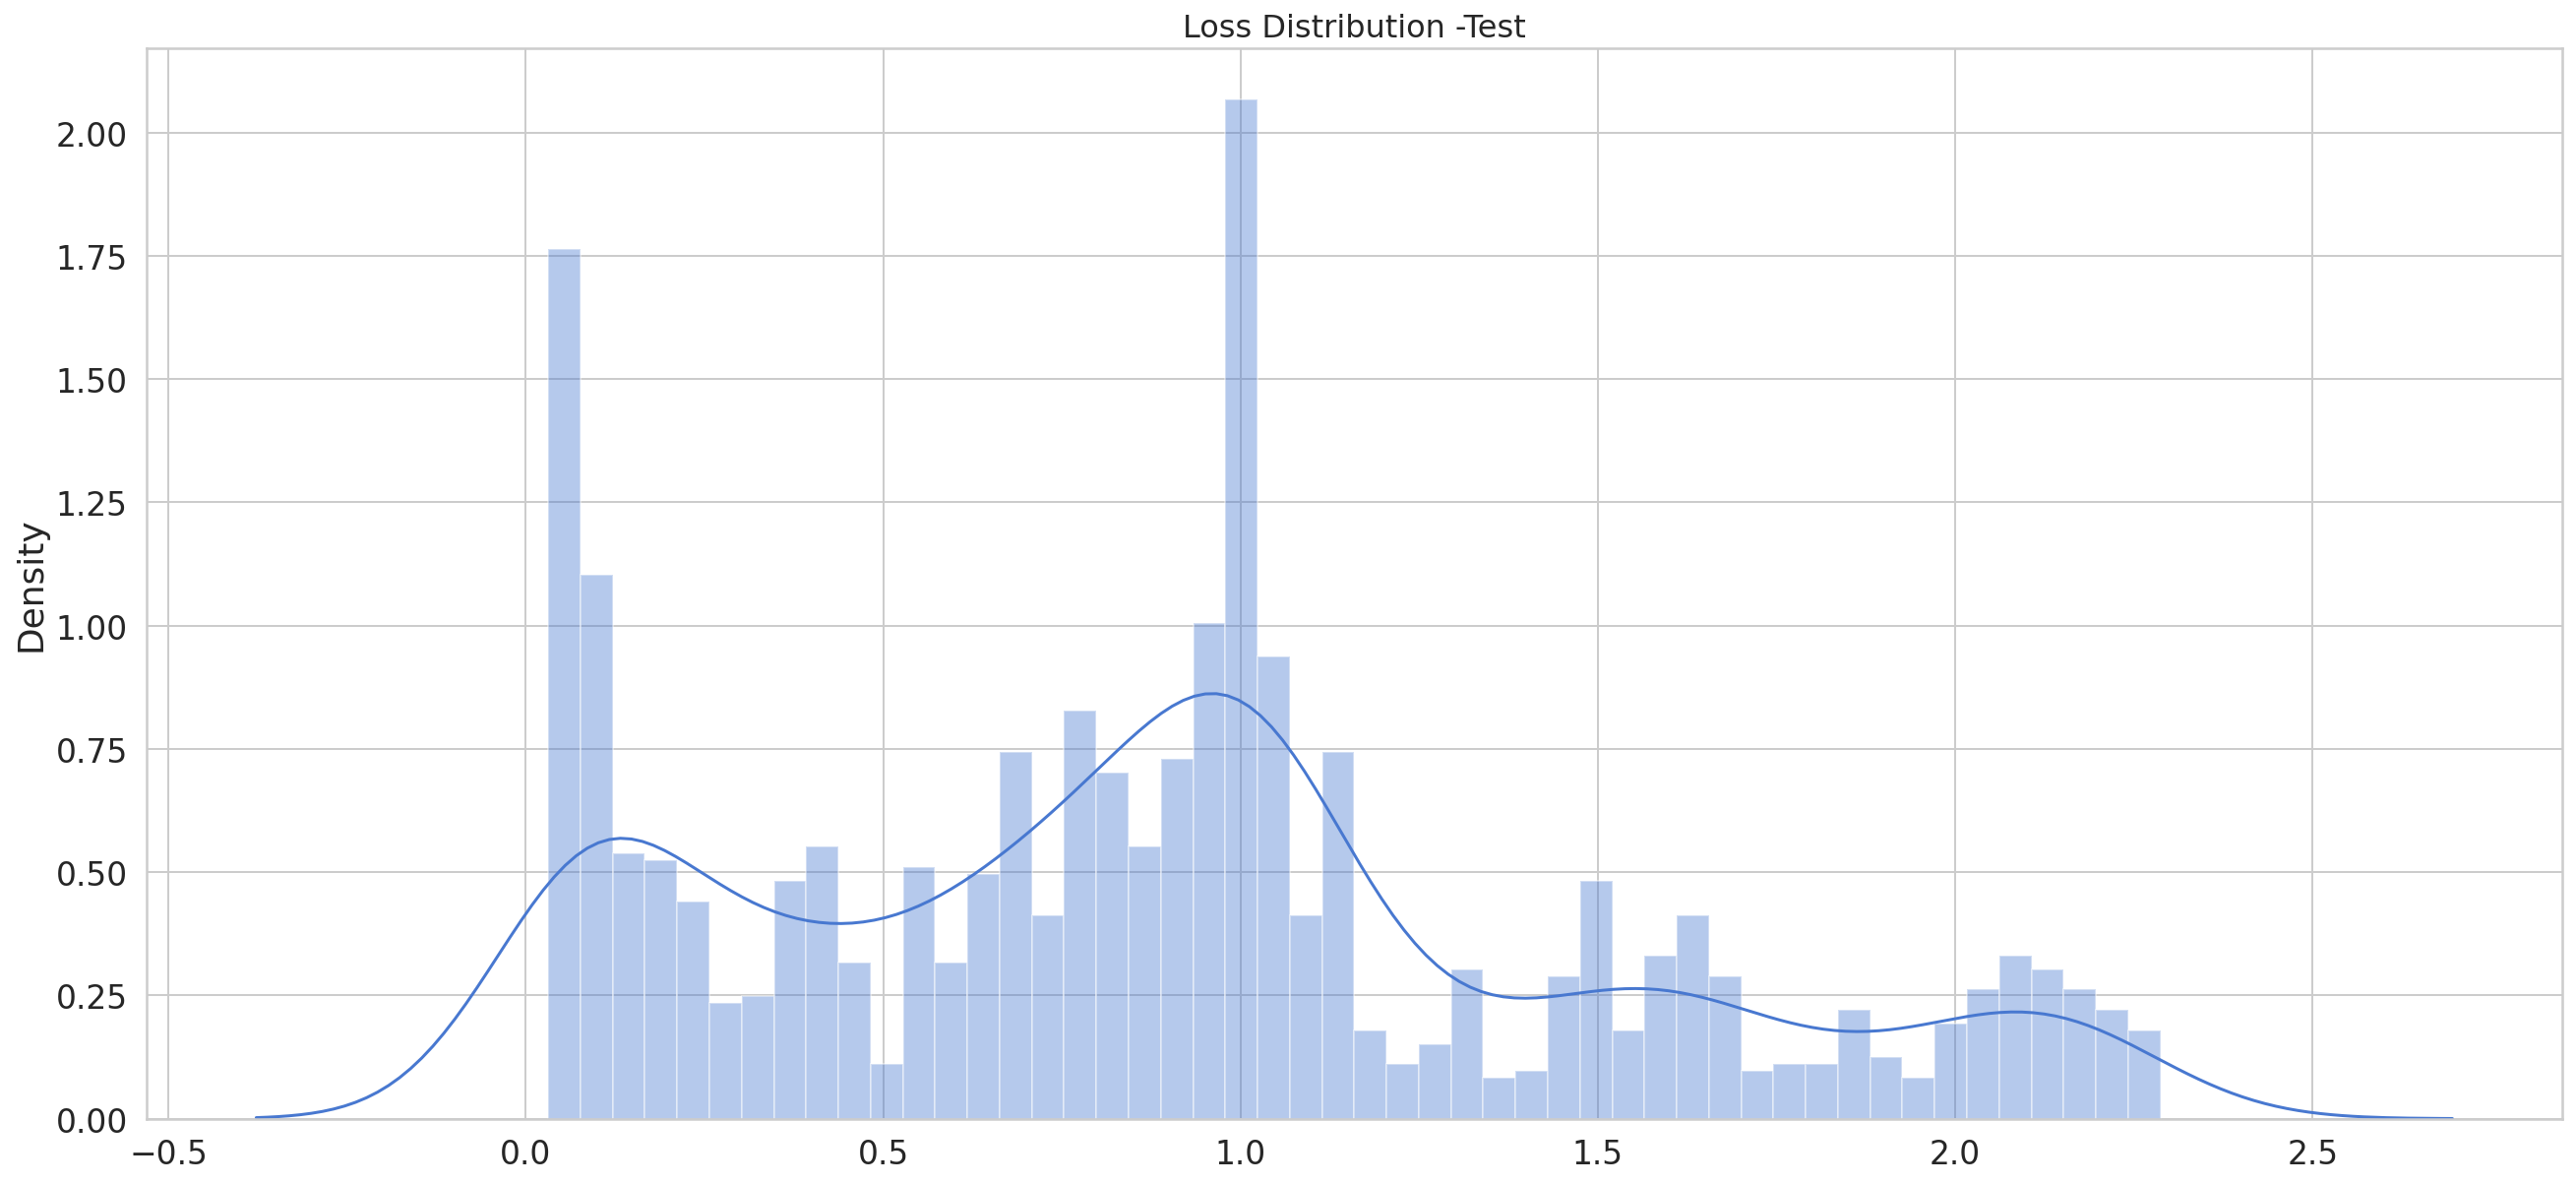

In [32]:
plt.title('Loss Distribution -Test', fontsize=16)
sns.distplot(test_mae_loss, bins=50, kde=True);

In [33]:
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss

#calculate threshold by std deviation *3

std_x_train=np.std(test_score_df.loss)*3
mean_x_train=np.mean(test_score_df.loss)

THRESHOLD = std_x_train

test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

THRESHOLD

1.7880170773978934

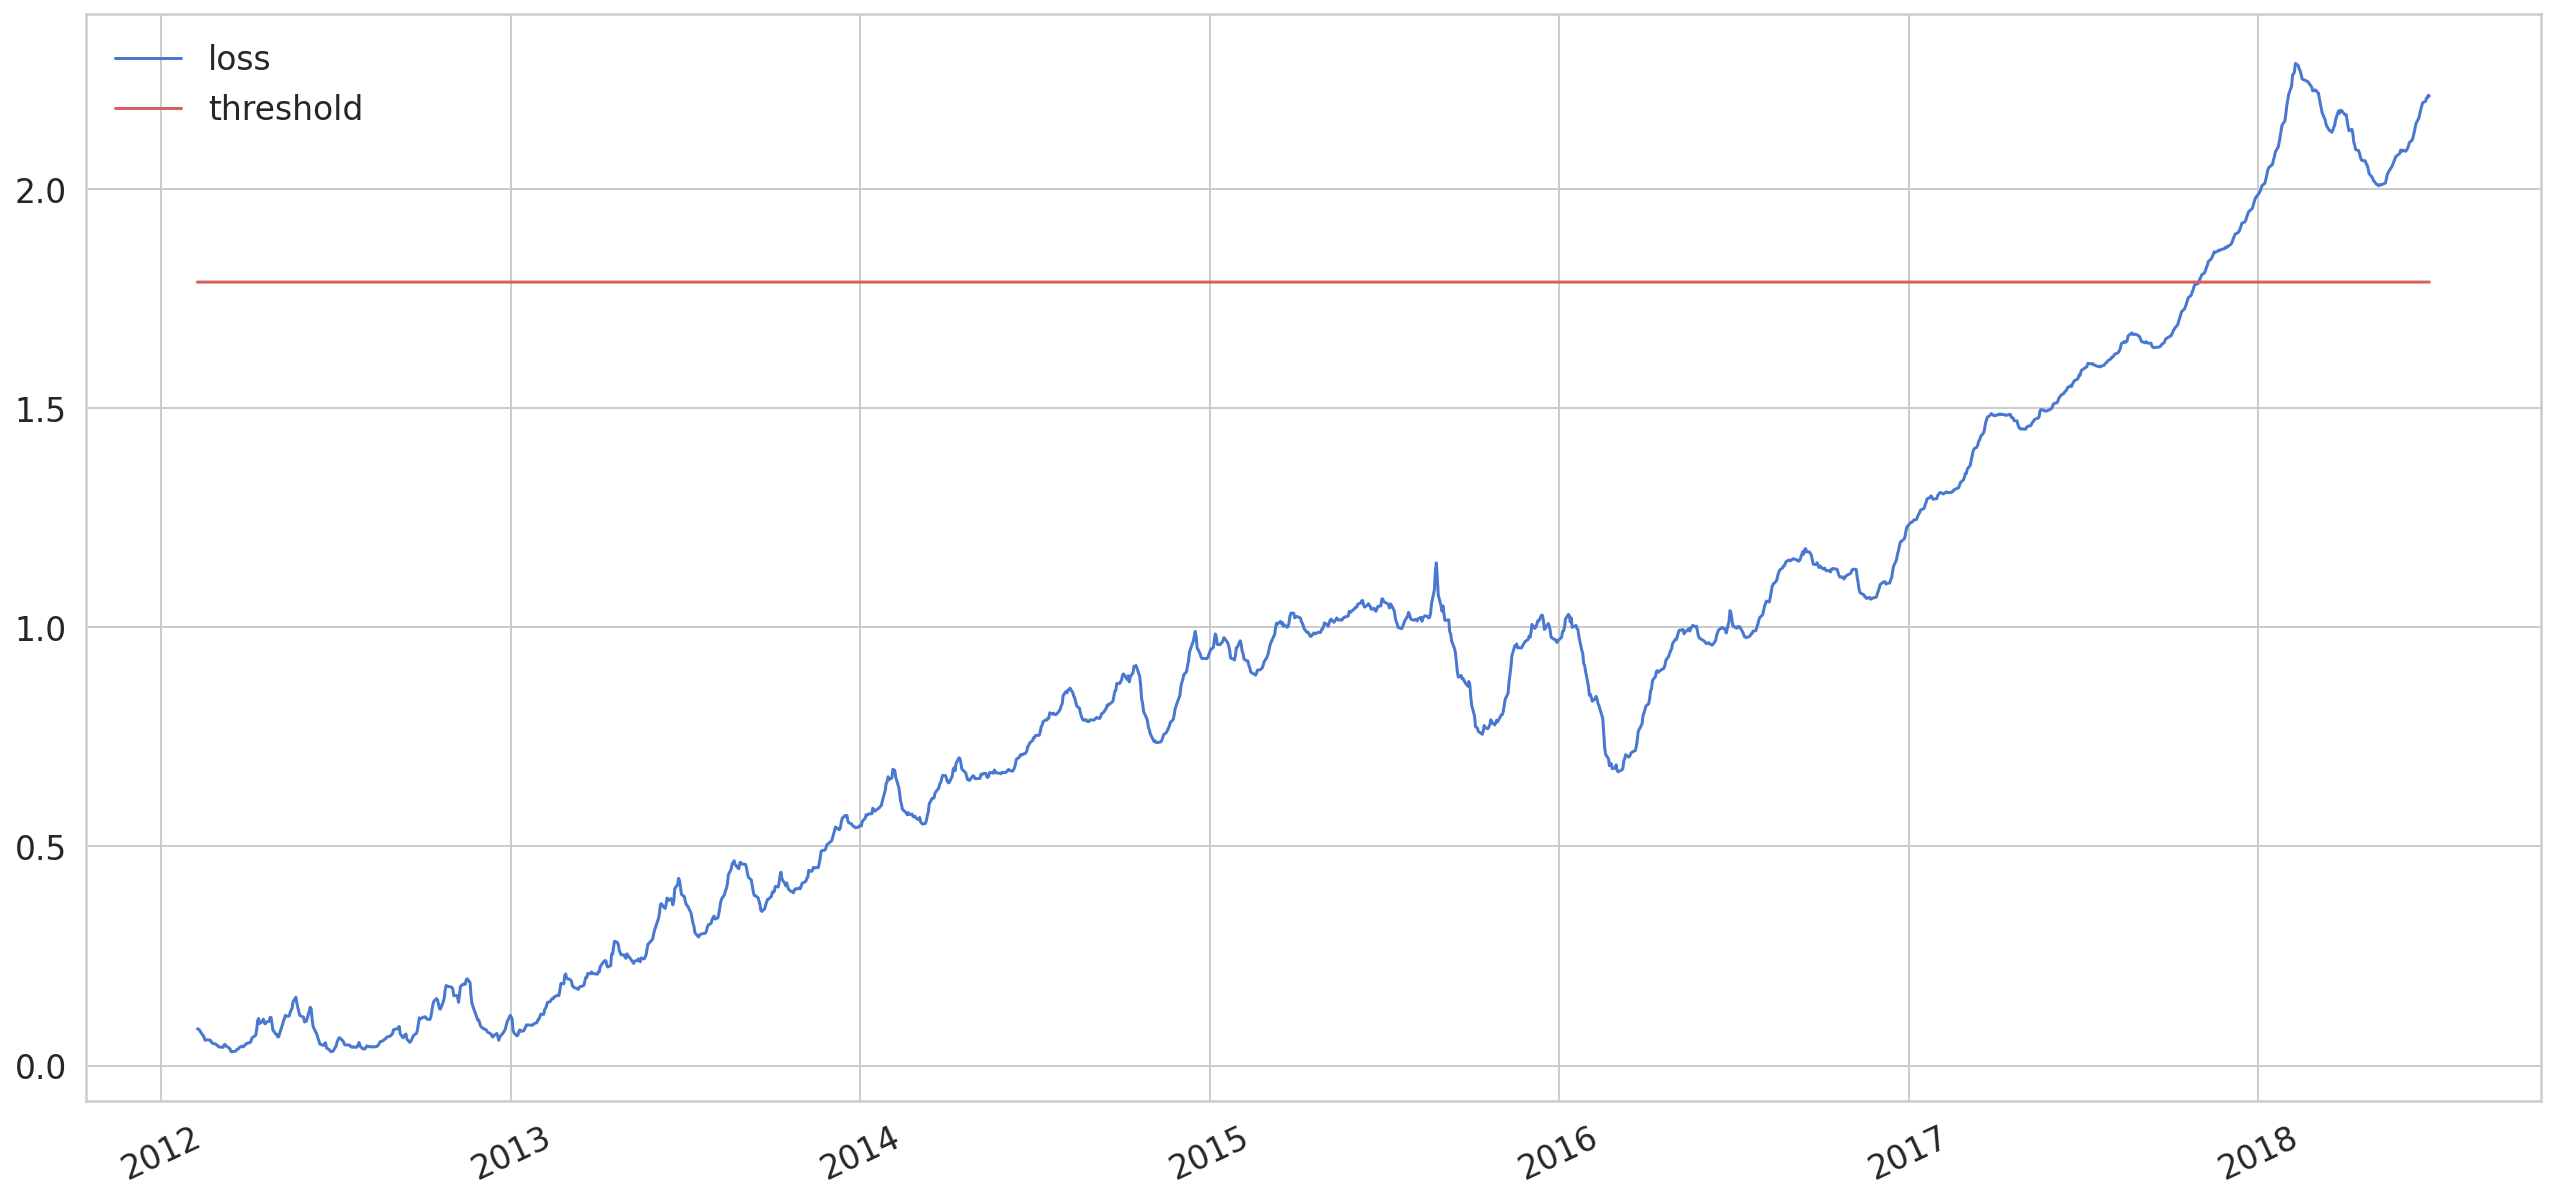

In [34]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold', color="r")
plt.xticks(rotation=25)
plt.legend();

In [35]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head(30)

,loss,threshold,anomaly,close
date,,,,
2017-10-31,1.790052,1.788017,True,4.153370
2017-11-01,1.794527,1.788017,True,4.163196
2017-11-02,1.798824,1.788017,True,4.164371
2017-11-03,1.804454,1.788017,True,4.183519
2017-11-06,1.808852,1.788017,True,4.191404
2017-11-07,1.814653,1.788017,True,4.190230
2017-11-08,1.821425,1.788017,True,4.199193
2017-11-09,1.827009,1.788017,True,4.175802
2017-11-10,1.834888,1.788017,True,4.170242


In [36]:
anomalies_str=str(anomalies.count())
anomalies_str

'loss         167\nthreshold    167\nanomaly      167\nclose        167\ndtype: int64'